In [2]:
#Cell 1
#importing libraries
import numpy as np
import pandas as pd
import math
import operator
import random
import matplotlib.pyplot as plt
import warnings

In [3]:
#Cell 2

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance_to(self, other):
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    
    def __repr__(self):
        return f"({self.x}, {self.y})"


In [4]:
#Cell 3
def create_distance_matrix(cities):
    n = len(cities)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i, j] = cities[i].distance_to(cities[j])
    return distance_matrix


In [5]:
#Cell 4
citylist = [City(x=int(random.random() * 200), y=int(random.random() * 200)) for _ in range(25)]
#citylist= [City(x=150,y=82),City(x=130,y=70),City(x=130,y=90),City(x=110,y=38),City(x=100,y=40),City(x=100,y=60),City(x=100,y=120),City(x=100,y=140),City(x=100,y=160),City(x=100,y=180),City(x=100,y=200),City(x=80,y=20),City(x=80,y=40),City(x=80,y=60),City(x=80,y=80),City(x=80,y=100),City(x=80,y=120),City(x=80,y=140),City(x=80,y=160),City(x=80,y=180),City(x=80,y=200),City(x=60,y=20),City(x=60,y=40),City(x=60,y=60),City(x=60,y=80)]
print("Cities : ", citylist)

distance_matrix = create_distance_matrix(citylist)


Cities :  [(161, 60), (38, 148), (96, 116), (73, 81), (20, 36), (152, 10), (164, 188), (135, 109), (102, 98), (113, 135), (163, 21), (192, 54), (25, 185), (67, 190), (15, 58), (63, 8), (2, 105), (21, 12), (157, 187), (128, 25), (71, 85), (5, 129), (185, 20), (44, 163), (90, 130)]


In [6]:
#Cell 5
# Parameters for the ACO
num_ants = 50
num_iterations = 100
alpha = 1.0
beta = 2.0
rho = 0.5
Q = 1.0
meeting_phases = 3
selective_ratio = 0.5

# PSO parameters
num_particles = 50
num_iterations = 100
inertia_weight = 0.9
cognitive_coeff = 1.5
social_coeff = 1.5

In [7]:
#cell 6

warnings.filterwarnings("ignore", category=RuntimeWarning) # Ignore RuntimeWarning
def initialize_pheromone_matrix(n):
    return np.ones((n, n)) / n

def calculate_probabilities(pheromones, distances, alpha, beta, visited, current_city):
    pheromone = np.copy(pheromones[current_city])
    pheromone[list(visited)] = 0.0
    visibility = 1 / distances[current_city]
    probabilities = np.power(pheromone, alpha) * np.power(visibility, beta)
    
    # Handle NaN or infinity in probabilities
    probabilities[np.isnan(probabilities)] = 0.0
    probabilities[np.isinf(probabilities)] = 0.0
    
    # Normalize probabilities to sum to 1 (if they are not already)
    if np.sum(probabilities) > 0:
        probabilities = probabilities / np.sum(probabilities)
    else:
        probabilities = np.ones_like(probabilities) / len(probabilities)
    
    return probabilities

def update_pheromones(pheromones, delta_pheromones, rho):
    return (1 - rho) * pheromones + delta_pheromones

# Helper functions for PSO
warnings.filterwarnings("ignore", category=RuntimeWarning)

def create_initial_population(num_particles, num_nodes):
    population = []
    for _ in range(num_particles):
        particle = np.random.permutation(num_nodes)
        population.append(particle)
    return population

def calculate_fitness(particle, distance_matrix):
    fitness = 0
    for i in range(len(particle) - 1):
        fitness += distance_matrix[particle[i], particle[i + 1]]
    fitness += distance_matrix[particle[-1], particle[0]]
    return fitness

def update_velocity(particle, velocity, best_personal_position, best_global_position, inertia_weight, cognitive_coeff, social_coeff):
    new_velocity = inertia_weight * velocity
    cognitive_component = cognitive_coeff * np.random.random() * (best_personal_position - particle)
    social_component = social_coeff * np.random.random() * (best_global_position - particle)
    new_velocity += cognitive_component + social_component
    return new_velocity

def apply_velocity(particle, velocity):
    new_particle = particle + velocity
    new_particle = np.mod(new_particle, len(particle))
    new_particle = np.argsort(new_particle)
    return new_particle

In [8]:
#Cell 7
# Local search function for PSO (2-opt)
def two_opt_local_search(route, distance_matrix, max_iterations=100):
    best_route = route.copy()
    best_distance = calculate_fitness(best_route, distance_matrix)
    improved = True
    iteration = 0

    while improved and iteration < max_iterations:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                new_route = two_opt_swap(best_route, i, j)
                new_distance = calculate_fitness(new_route, distance_matrix)
                if new_distance < best_distance:
                    best_route = new_route
                    best_distance = new_distance
                    improved = True
        iteration += 1

    return best_route, best_distance

def two_opt_swap(route, i, j):
    new_route = route.copy()
    new_route[i:j+1] = route[j:i-1:-1]
    return new_route

In [9]:
#Cell 8
# Implementing ACO with Enhanced Meeting Strategy for TSP
def aco_meeting_strategy(cities, num_ants, num_iterations, alpha, beta, rho, Q, meeting_phases, selective_ratio):
    num_cities = len(cities)
    distances = create_distance_matrix(cities)
    pheromones = initialize_pheromone_matrix(num_cities)
    
    best_distance = float('inf')
    best_path = []
    
    for iteration in range(num_iterations):
        ant_paths = [[] for _ in range(num_ants)]
        candidate_list = [[] for _ in range(num_ants)]
        
        for k in range(num_ants):
            current_city = random.randint(0, num_cities - 1)
            ant_paths[k].append(current_city)
            candidate_list[k].append(current_city)
            visited = set(ant_paths[k])
            
            while len(ant_paths[k]) < num_cities:
                probabilities = calculate_probabilities(pheromones, distances, alpha, beta, visited, current_city)
                next_city = np.random.choice(range(num_cities), p=probabilities)
                
                ant_paths[k].append(next_city)
                candidate_list[k].append(next_city)
                visited.add(next_city)
                current_city = next_city
        
        # Calculate fitness for all ants
        ant_fitnesses = [calculate_tour_length(ant_paths[k], distances) for k in range(num_ants)]
        
        for _ in range(meeting_phases):
            # Select top performing ants for meetings
            selected_ants = np.argsort(ant_fitnesses)[:int(num_ants * selective_ratio)]
            
            # Combine tours from selected ants
            combined_tour = []
            for ant in selected_ants:
                combined_tour.extend(candidate_list[ant])
            
            combined_tour = remove_duplicates(combined_tour)
            
            # Only update pheromones if combined_tour is not empty
            if len(combined_tour) > 1:  # Need at least 2 cities to form a path
                # Update pheromones based on combined tour
                delta_pheromones = np.zeros((num_cities, num_cities))
                for i in range(len(combined_tour) - 1):
                    city_i = combined_tour[i]
                    city_j = combined_tour[i + 1]
                    delta_pheromones[city_i, city_j] += Q / distances[city_i, city_j]
                delta_pheromones[combined_tour[-1], combined_tour[0]] += Q / distances[combined_tour[-1], combined_tour[0]]
                
                pheromones = update_pheromones(pheromones, delta_pheromones, rho)
            
            # Reset candidate list for next phase
            candidate_list = [[] for _ in range(num_ants)]
        
        # Update best path
        for k in range(num_ants):
            if ant_fitnesses[k] < best_distance:
                best_distance = ant_fitnesses[k]
                best_path = ant_paths[k]
        
        # Global pheromone update
        if best_path:  # Only update if we have a best path
            global_update(pheromones, best_path, best_distance, Q)
    
    return best_path, best_distance

def calculate_tour_length(tour, distances):
    if len(tour) < 2:  # Handle case of incomplete tour
        return float('inf')
    return sum(distances[tour[i], tour[i + 1]] for i in range(len(tour) - 1)) + distances[tour[-1], tour[0]]

def remove_duplicates(tour):
    return list(dict.fromkeys(tour))

def global_update(pheromones, best_path, best_distance, Q):
    if len(best_path) < 2:  # Check if path is valid
        return
    for i in range(len(best_path) - 1):
        city_i = best_path[i]
        city_j = best_path[i + 1]
        pheromones[city_i, city_j] += Q / best_distance
    pheromones[best_path[-1], best_path[0]] += Q / best_distance

# Running the enhanced ACO with meeting strategy
best_path, best_distance = aco_meeting_strategy(citylist, num_ants, num_iterations, alpha, beta, rho, Q, meeting_phases, selective_ratio)
print(f"Best path found: {best_path} with length {best_distance}")


# Hybrid PSO algorithm implementation for TSP
def hybrid_pso_tsp(distance_matrix, num_particles, num_iterations, inertia_weight, cognitive_coeff, social_coeff):
    num_nodes = distance_matrix.shape[0]
    population = create_initial_population(num_particles, num_nodes)
    velocities = [np.zeros(num_nodes) for _ in range(num_particles)]
    
    best_personal_positions = population.copy()
    best_personal_fitnesses = [calculate_fitness(p, distance_matrix) for p in population]
    best_global_position = best_personal_positions[np.argmin(best_personal_fitnesses)]
    best_global_fitness = min(best_personal_fitnesses)
    
    for iteration in range(num_iterations):
        for i in range(num_particles):
            # Apply PSO update
            velocities[i] = update_velocity(population[i], velocities[i], best_personal_positions[i], best_global_position, inertia_weight, cognitive_coeff, social_coeff)
            population[i] = apply_velocity(population[i], velocities[i])
            
            # Apply local search
            improved_route, improved_fitness = two_opt_local_search(population[i], distance_matrix)
            population[i] = improved_route
            
            if improved_fitness < best_personal_fitnesses[i]:
                best_personal_fitnesses[i] = improved_fitness
                best_personal_positions[i] = improved_route
            if improved_fitness < best_global_fitness:
                best_global_fitness = improved_fitness
                best_global_position = improved_route
        
        print(f"Iteration {iteration + 1}/{num_iterations}, Best path length: {best_global_fitness}")
    
    return best_global_position, best_global_fitness

# Running the Hybrid PSO algorithm
best_path, best_path_length = hybrid_pso_tsp(distance_matrix, num_particles, num_iterations, inertia_weight, cognitive_coeff, social_coeff)
print(f"Best path found using Hybrid PSO: {best_path} with length {best_path_length}")

Best path found: [21, 1, 23, 12, 13, 18, 6, 9, 24, 2, 20, 3, 8, 7, 0, 11, 22, 10, 5, 19, 15, 17, 4, 14, 16] with length 864.2894603425522
Iteration 1/100, Best path length: 864.2894603425522
Iteration 2/100, Best path length: 864.2894603425522
Iteration 3/100, Best path length: 864.2894603425522
Iteration 4/100, Best path length: 864.2894603425522
Iteration 5/100, Best path length: 864.2894603425522
Iteration 6/100, Best path length: 864.2894603425522
Iteration 7/100, Best path length: 864.2894603425522
Iteration 8/100, Best path length: 864.2894603425522
Iteration 9/100, Best path length: 864.2894603425522
Iteration 10/100, Best path length: 864.2894603425522
Iteration 11/100, Best path length: 864.2894603425522
Iteration 12/100, Best path length: 864.2894603425522
Iteration 13/100, Best path length: 864.2894603425522
Iteration 14/100, Best path length: 864.2894603425522
Iteration 15/100, Best path length: 864.2894603425522
Iteration 16/100, Best path length: 864.2894603425522
Iterati

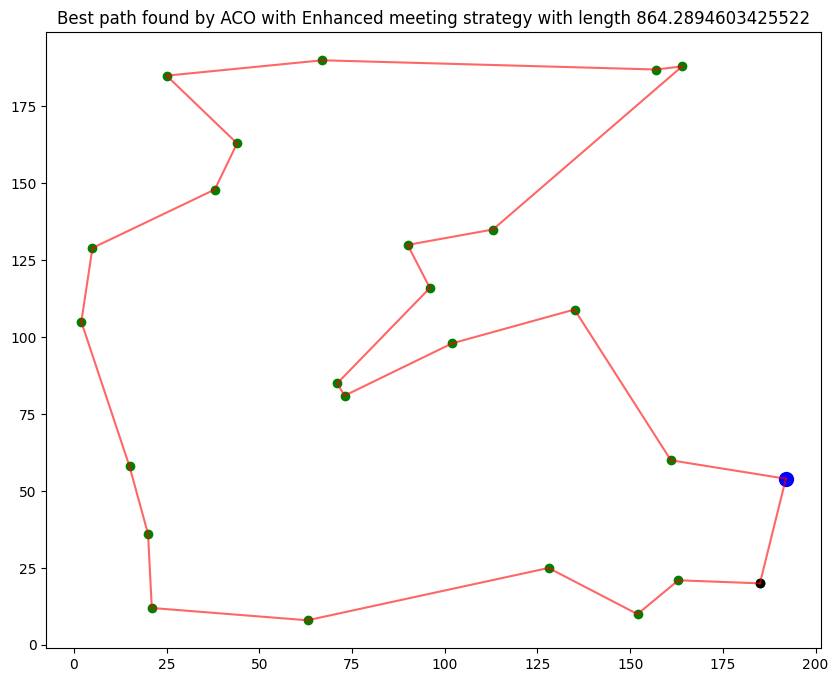

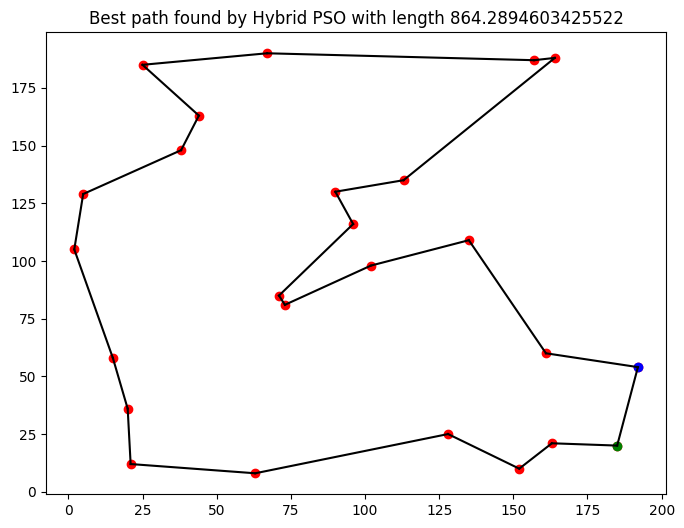

In [10]:
#Cell 9
# Visualizing the best path
plt.figure(figsize=(10, 8))
plt.title(f"Best path found by ACO with Enhanced meeting strategy with length {best_distance}")
plt.scatter([city.x for city in citylist], [city.y for city in citylist], color='green')
for i in range(len(best_path)):
    start = citylist[best_path[i]]
    end = citylist[best_path[(i + 1) % len(best_path)]]
    plt.plot([start.x, end.x], [start.y, end.y], color='red', alpha=0.6)

#color to starting point
plt.scatter(citylist[best_path[0]].x, citylist[best_path[0]].y, color='blue' , s=100, label='Start')
#color to ending point
plt.scatter(citylist[best_path[-1]].x, citylist[best_path[-1]].y, color='black')
plt.scatter
plt.show()

# Plotting the result
def plot_tsp_path(citylist, path):
    coordinates = [(city.x, city.y) for city in citylist]
    plt.figure(figsize=(8, 6))
    for i in range(len(path)):
        start = coordinates[path[i]]
        end = coordinates[path[(i + 1) % len(path)]]
        plt.plot([start[0], end[0]], [start[1], end[1]], 'black') 
    plt.scatter(*zip(*coordinates), color='red')
    #color to starting point
    plt.scatter(*coordinates[path[0]], color='blue')
    #color to ending point
    plt.scatter(*coordinates[path[-1]], color='green')
    plt.title(f"Best path found by Hybrid PSO with length {best_path_length}")
    plt.show()

plot_tsp_path(citylist, best_path)

In [11]:
#Cell 10
# Hyperparameter tuning for ACO and PSO using grid search
import time
from itertools import product

def hyperparameter_tuning(algorithm, citylist, param_grid, num_iterations=100, num_runs=5):
    best_params = None
    best_performance = float('inf')
    results = []

    for params in product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        
        performance_metrics = []
        for _ in range(num_runs):
            start_time = time.time()
            if algorithm == "ACO":
                best_path, best_distance = aco_meeting_strategy(citylist, num_iterations=num_iterations, **param_dict)
            else:  # PSO
                distance_matrix = create_distance_matrix(citylist)
                best_path, best_distance = hybrid_pso_tsp(distance_matrix, num_iterations=num_iterations, **param_dict)
            end_time = time.time()
            
            performance_metrics.append({
                'best_distance': best_distance,
                'computation_time': end_time - start_time
            })
        
        avg_performance = sum(m['best_distance'] for m in performance_metrics) / num_runs
        avg_time = sum(m['computation_time'] for m in performance_metrics) / num_runs
        
        results.append({
            'params': param_dict,
            'avg_performance': avg_performance,
            'avg_time': avg_time
        })
        
        if avg_performance < best_performance:
            best_performance = avg_performance
            best_params = param_dict

    return best_params, results

In [12]:
#Cell 11
#Grid search for ACO
aco_param_grid = {
    'num_ants': [3, 5, 7],
    'alpha': [0.5, 1.0, 1.5],
    'beta': [1.5, 2.0, 2.5],
    'rho': [0.3, 0.5, 0.7],
    'Q': [0.8, 1.0, 1.2],
    'meeting_phases': [2, 3, 4],
    'selective_ratio': [0.3, 0.5, 0.7]
}

#Grid search for PSO
pso_param_grid = {
    'num_particles': [3, 5, 7],
    'inertia_weight': [0.7, 0.9, 1.1],
    'cognitive_coeff': [1.0, 1.5, 2.0],
    'social_coeff': [1.0, 1.5, 2.0]
}

In [13]:
#Cell 12
# Running hyperparameter tuning for ACO and PSO
aco_best_params, aco_results = hyperparameter_tuning("ACO", citylist, aco_param_grid, num_iterations=5, num_runs=2)
print("Results for ACO: ", aco_results)
print("Best parameters for ACO: ", aco_best_params)

pso_best_params, pso_results = hyperparameter_tuning("PSO", citylist, pso_param_grid, num_iterations=5, num_runs=2)
print("Results for PSO: ", pso_results)
print("Best parameters for PSO: ", pso_best_params)

Results for ACO:  [{'params': {'num_ants': 3, 'alpha': 0.5, 'beta': 1.5, 'rho': 0.3, 'Q': 0.8, 'meeting_phases': 2, 'selective_ratio': 0.3}, 'avg_performance': 1639.9981061850783, 'avg_time': 0.05076169967651367}, {'params': {'num_ants': 3, 'alpha': 0.5, 'beta': 1.5, 'rho': 0.3, 'Q': 0.8, 'meeting_phases': 2, 'selective_ratio': 0.5}, 'avg_performance': 1520.775505763666, 'avg_time': 0.046099305152893066}, {'params': {'num_ants': 3, 'alpha': 0.5, 'beta': 1.5, 'rho': 0.3, 'Q': 0.8, 'meeting_phases': 2, 'selective_ratio': 0.7}, 'avg_performance': 1408.2389296932417, 'avg_time': 0.04852283000946045}, {'params': {'num_ants': 3, 'alpha': 0.5, 'beta': 1.5, 'rho': 0.3, 'Q': 0.8, 'meeting_phases': 3, 'selective_ratio': 0.3}, 'avg_performance': 1558.0825491380929, 'avg_time': 0.043749332427978516}, {'params': {'num_ants': 3, 'alpha': 0.5, 'beta': 1.5, 'rho': 0.3, 'Q': 0.8, 'meeting_phases': 3, 'selective_ratio': 0.5}, 'avg_performance': 1463.6916369186447, 'avg_time': 0.045334458351135254}, {'pa

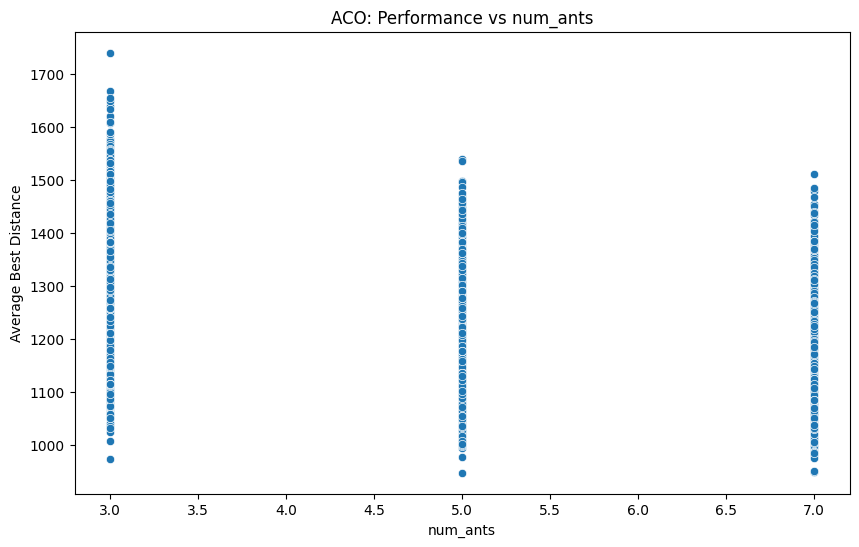

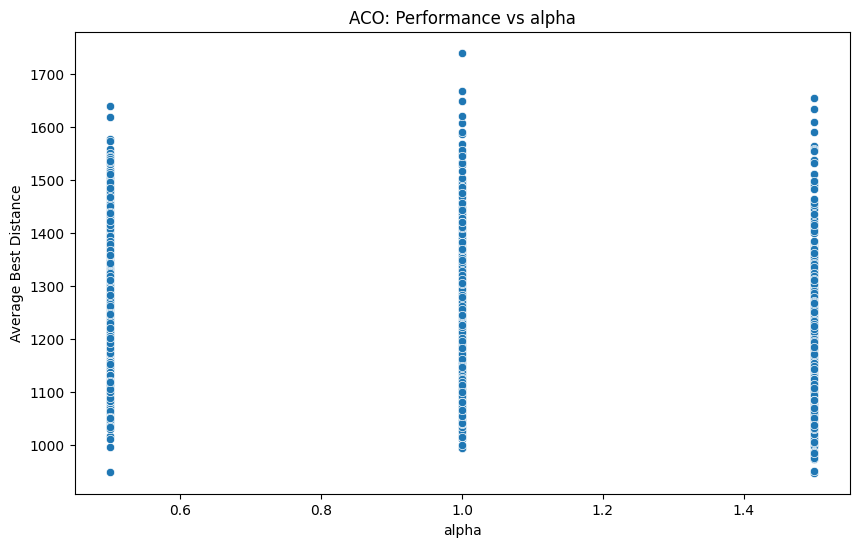

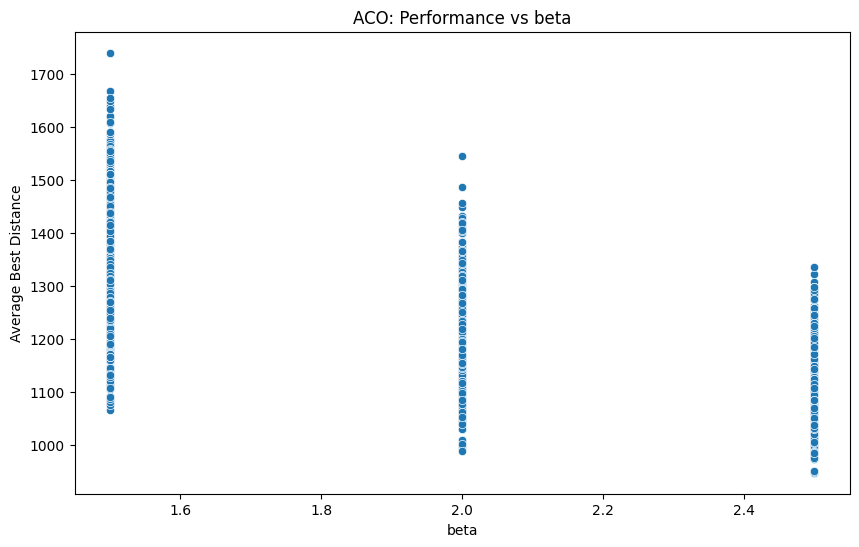

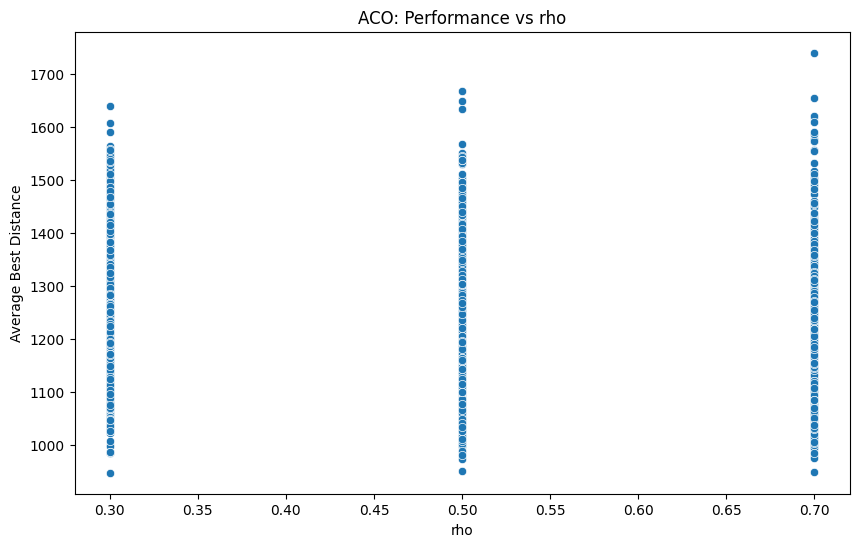

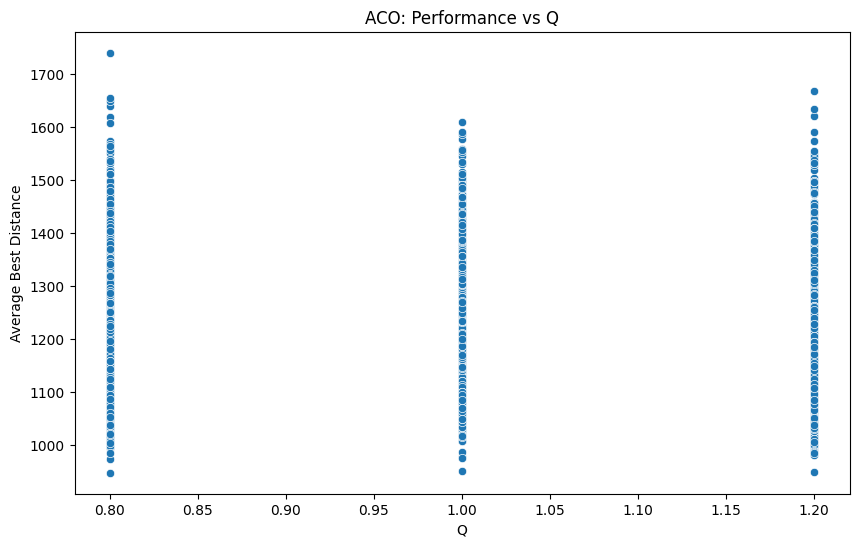

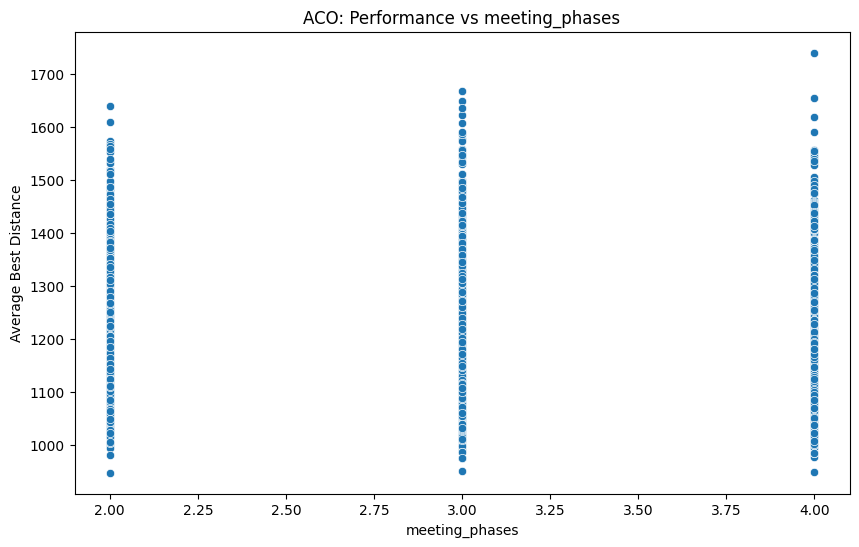

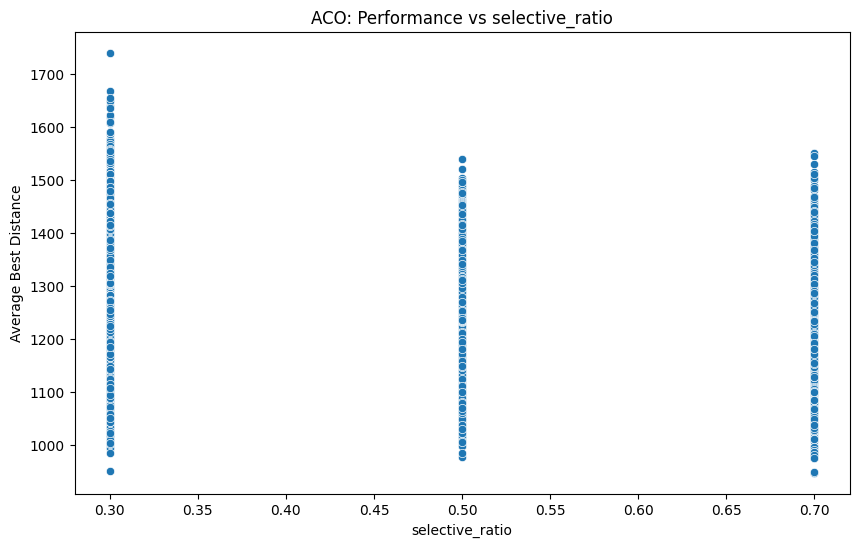

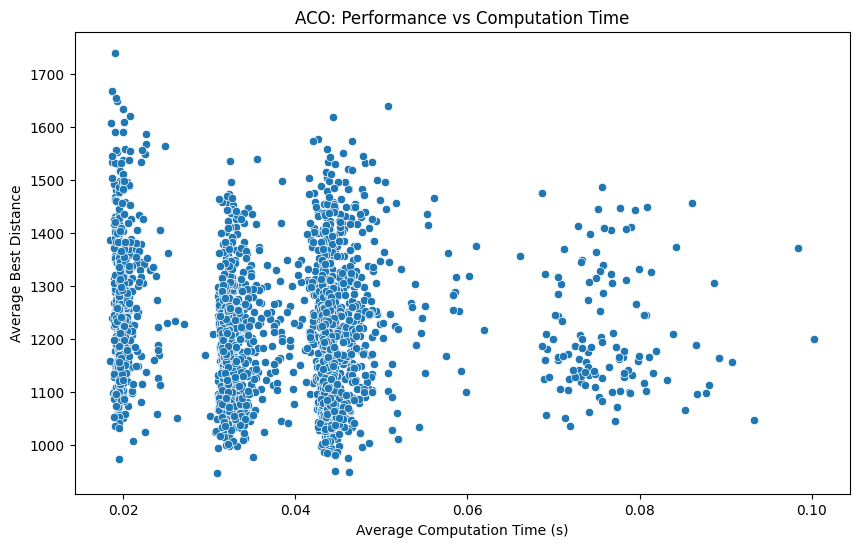

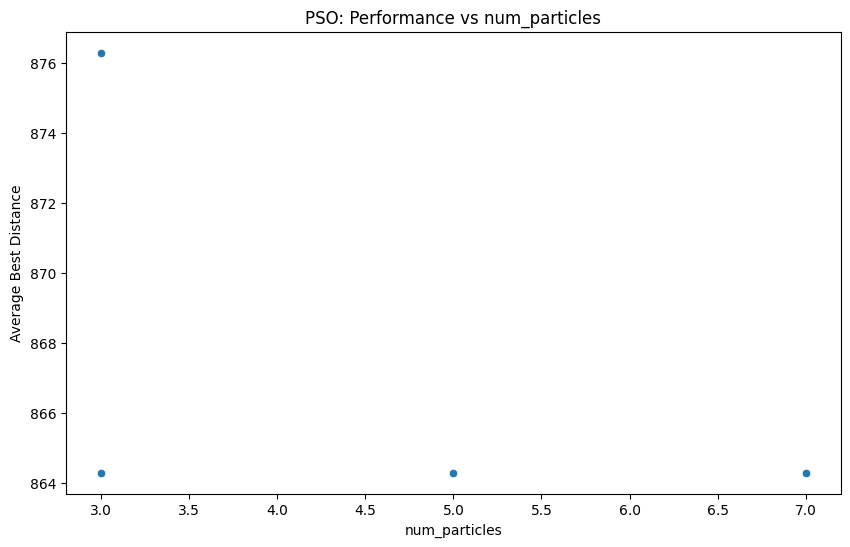

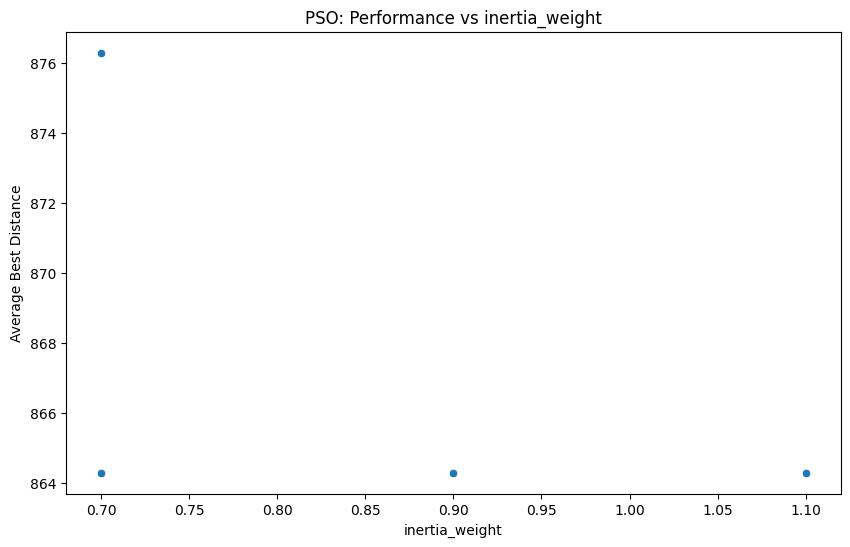

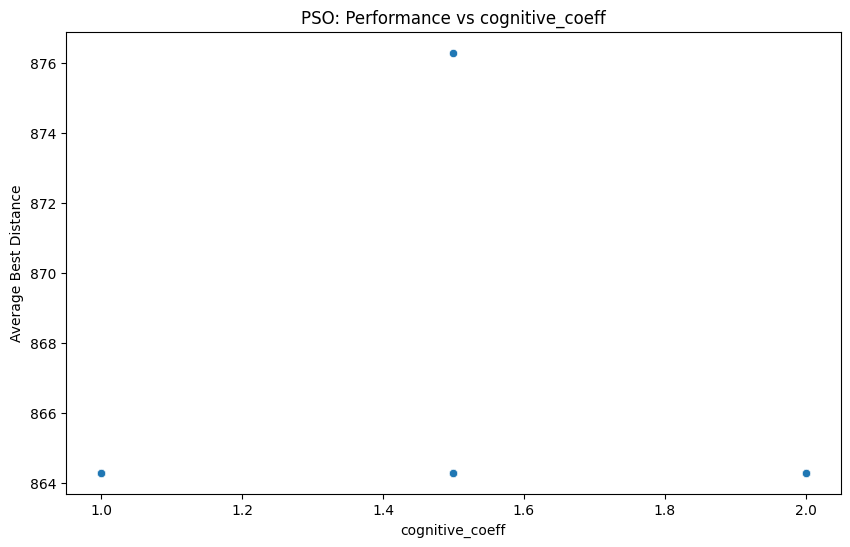

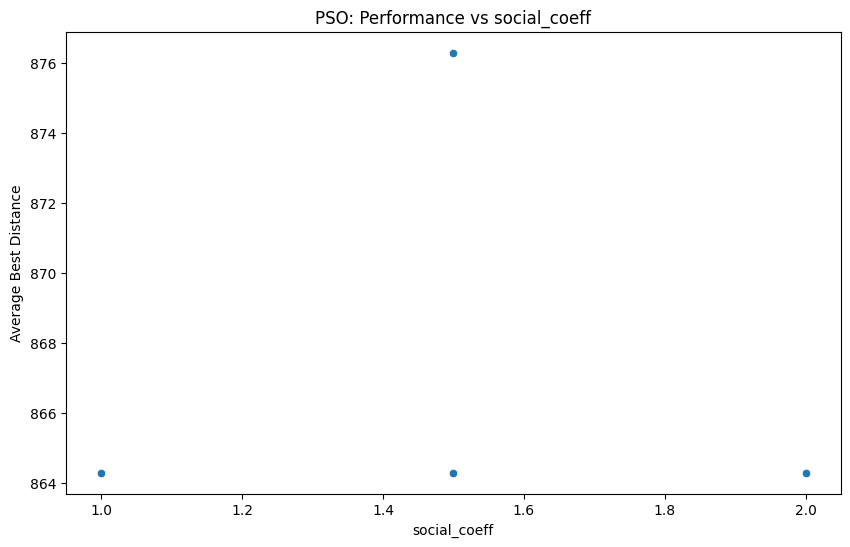

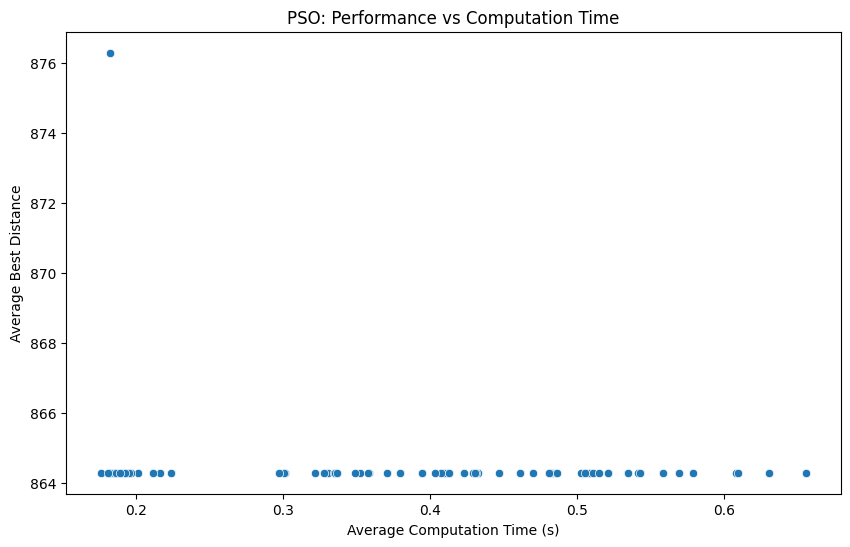

In [14]:
#Cell 13
# Analyzing the results and plotting the performance vs. hyperparameters
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(results, algorithm_name):
    df = pd.DataFrame(results)
    
    # Plot performance vs. different hyperparameters
    for param in df['params'].iloc[0].keys():
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df['params'].apply(lambda x: x[param]), y='avg_performance', data=df)
        plt.title(f'{algorithm_name}: Performance vs {param}')
        plt.xlabel(param)
        plt.ylabel('Average Best Distance')
        plt.show()
    
    # Plot computation time vs. performance
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='avg_time', y='avg_performance', data=df)
    plt.title(f'{algorithm_name}: Performance vs Computation Time')
    plt.xlabel('Average Computation Time (s)')
    plt.ylabel('Average Best Distance')
    plt.show()

analyze_results(aco_results, "ACO")
analyze_results(pso_results, "PSO")

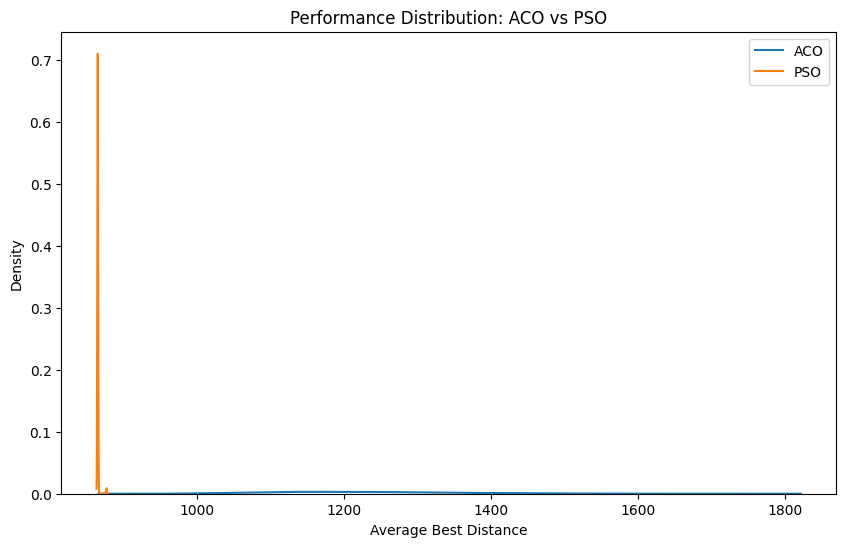

ACO Best Performance: 947.1018729247623
ACO Best Parameters: {'num_ants': 5, 'alpha': 1.5, 'beta': 2.5, 'rho': 0.3, 'Q': 0.8, 'meeting_phases': 2, 'selective_ratio': 0.7}
PSO Best Performance: 864.2894603425522
PSO Best Parameters: {'num_particles': 3, 'inertia_weight': 0.7, 'cognitive_coeff': 1.0, 'social_coeff': 1.0}
ACO Average Time: 0.03790858378408159
PSO Average Time: 0.3621982247741134


In [15]:
#Cell 14
# Performance comparison Algorithm for ACO and PSO
def compare_algorithms(aco_results, pso_results):
    aco_df = pd.DataFrame(aco_results)
    pso_df = pd.DataFrame(pso_results)
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=aco_df['avg_performance'], label='ACO')
    sns.kdeplot(data=pso_df['avg_performance'], label='PSO')
    plt.title('Performance Distribution: ACO vs PSO')
    plt.xlabel('Average Best Distance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    print("ACO Best Performance:", aco_df['avg_performance'].min())
    print("ACO Best Parameters:", aco_df.loc[aco_df['avg_performance'].idxmin()]['params'])
    print("PSO Best Performance:", pso_df['avg_performance'].min())
    print("PSO Best Parameters:", pso_df.loc[pso_df['avg_performance'].idxmin()]['params'])
    print("ACO Average Time:", aco_df['avg_time'].mean())
    print("PSO Average Time:", pso_df['avg_time'].mean())

compare_algorithms(aco_results, pso_results)

In [16]:
#Helper functions
def initialize_pheromone_matrix(n):
    return np.ones((n, n))

def calculate_probabilities(pheromone, visibility, alpha, beta):
    return (pheromone ** alpha) * (visibility ** beta)

def update_pheromones(pheromones, delta_pheromones, evaporation_rate):
    return (1 - evaporation_rate) * pheromones + delta_pheromones

def delta_pheromones_for_ant(ant_path, Q, distance_matrix):
    n = len(ant_path)
    delta_pheromones = np.zeros((n, n))
    for i in range(n - 1):
        delta_pheromones[ant_path[i], ant_path[i + 1]] = Q / distance_matrix[ant_path[i], ant_path[i + 1]]
    delta_pheromones[ant_path[-1], ant_path[0]] = Q / distance_matrix[ant_path[-1], ant_path[0]]
    return delta_pheromones

In [17]:
# Implementing the Ant Colony Optimization algorithm
def aco_tsp(distance_matrix, num_ants, num_iterations, alpha, beta, rho, Q):
    num_nodes = distance_matrix.shape[0]
    pheromone_matrix = initialize_pheromone_matrix(num_nodes)
    best_path = None
    best_path_length = np.inf
    
    visibility = 1 / (distance_matrix + np.eye(num_nodes))  # Adding np.eye to avoid division by zero

    for iteration in range(num_iterations):
        ant_paths = []
        for ant in range(num_ants):
            visited_nodes = [np.random.randint(num_nodes)]
            while len(visited_nodes) < num_nodes:
                current_node = visited_nodes[-1]
                probabilities = calculate_probabilities(pheromone_matrix[current_node], visibility[current_node], alpha, beta)
                probabilities[visited_nodes] = 0
                probabilities /= probabilities.sum()
                next_node = np.random.choice(range(num_nodes), p=probabilities)
                visited_nodes.append(next_node)
            ant_paths.append(visited_nodes)
        
        all_delta_pheromones = np.zeros((num_nodes, num_nodes))
        for path in ant_paths:
            path_length = sum(distance_matrix[path[i], path[i+1]] for i in range(num_nodes - 1))
            path_length += distance_matrix[path[-1], path[0]]
            if path_length < best_path_length:
                best_path_length = path_length
                best_path = path
            
            delta_pheromones = delta_pheromones_for_ant(path, Q, distance_matrix)
            all_delta_pheromones += delta_pheromones
        
        pheromone_matrix = update_pheromones(pheromone_matrix, all_delta_pheromones, rho)
        print(f"Iteration {iteration+1}/{num_iterations}, Best path length: {best_path_length}")
    
    return best_path, best_path_length

Iteration 1/100, Best path length: 1183.8617598792769
Iteration 2/100, Best path length: 1183.8617598792769
Iteration 3/100, Best path length: 1052.0000070789931
Iteration 4/100, Best path length: 1052.0000070789931
Iteration 5/100, Best path length: 987.2708738546816
Iteration 6/100, Best path length: 987.2708738546816
Iteration 7/100, Best path length: 973.4519983560913
Iteration 8/100, Best path length: 903.3508654695739
Iteration 9/100, Best path length: 903.3508654695739
Iteration 10/100, Best path length: 889.6342610060486
Iteration 11/100, Best path length: 889.6342610060486
Iteration 12/100, Best path length: 889.6342610060486
Iteration 13/100, Best path length: 876.6828619450105
Iteration 14/100, Best path length: 876.6828619450105
Iteration 15/100, Best path length: 876.6828619450105
Iteration 16/100, Best path length: 865.8249338595044
Iteration 17/100, Best path length: 865.8249338595044
Iteration 18/100, Best path length: 865.8249338595044
Iteration 19/100, Best path lengt

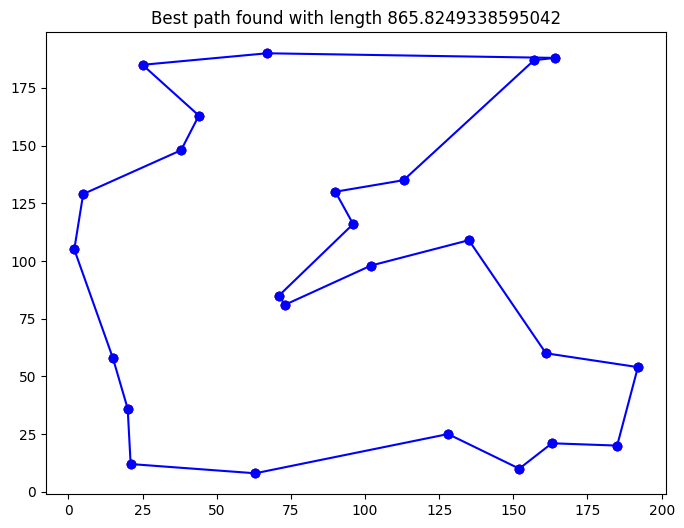

In [18]:
# Running the ACO algorithm and plotting the best path
best_path, best_path_length = aco_tsp(distance_matrix, num_ants, num_iterations, alpha, beta, rho, Q)
print(f"Best path found: {best_path} with length {best_path_length}")

# Plotting the best path
def plot_tsp_path(citylist, path):
    coordinates = [(city.x, city.y) for city in citylist]  # Extracting coordinates from City objects
    plt.figure(figsize=(8, 6))
    for i in range(len(path)):
        start = coordinates[path[i]]
        end = coordinates[path[(i + 1) % len(path)]]
        plt.plot([start[0], end[0]], [start[1], end[1]], 'bo-')
    plt.scatter(*zip(*coordinates), color='red')
    plt.title(f"Best path found with length {best_path_length}")
    plt.show()

plot_tsp_path(citylist, best_path)


In [19]:
# Cell 5: Helper functions
def create_initial_population(num_particles, num_nodes):
    population = []
    for _ in range(num_particles):
        particle = np.random.permutation(num_nodes)
        population.append(particle)
    return population

def calculate_fitness(particle, distance_matrix):
    fitness = 0
    for i in range(len(particle) - 1):
        fitness += distance_matrix[particle[i], particle[i + 1]]
    fitness += distance_matrix[particle[-1], particle[0]]
    return fitness

def update_velocity(particle, velocity, best_personal_position, best_global_position, inertia_weight, cognitive_coeff, social_coeff):
    new_velocity = inertia_weight * velocity
    cognitive_component = cognitive_coeff * np.random.random() * (best_personal_position - particle)
    social_component = social_coeff * np.random.random() * (best_global_position - particle)
    new_velocity += cognitive_component + social_component
    return new_velocity

def apply_velocity(particle, velocity):
    new_particle = particle + velocity
    new_particle = np.mod(new_particle, len(particle))
    new_particle = np.argsort(new_particle)
    return new_particle

In [20]:
# Cell 6: PSO algorithm implementation
def pso_tsp(distance_matrix, num_particles, num_iterations, inertia_weight, cognitive_coeff, social_coeff):
    num_nodes = distance_matrix.shape[0]
    population = create_initial_population(num_particles, num_nodes)
    velocities = [np.zeros(num_nodes) for _ in range(num_particles)]
    
    best_personal_positions = population.copy()
    best_personal_fitnesses = [calculate_fitness(p, distance_matrix) for p in population]
    best_global_position = best_personal_positions[np.argmin(best_personal_fitnesses)]
    best_global_fitness = min(best_personal_fitnesses)
    
    for iteration in range(num_iterations):
        for i in range(num_particles):
            fitness = calculate_fitness(population[i], distance_matrix)
            if fitness < best_personal_fitnesses[i]:
                best_personal_fitnesses[i] = fitness
                best_personal_positions[i] = population[i]
            if fitness < best_global_fitness:
                best_global_fitness = fitness
                best_global_position = population[i]
        
        for i in range(num_particles):
            velocities[i] = update_velocity(population[i], velocities[i], best_personal_positions[i], best_global_position, inertia_weight, cognitive_coeff, social_coeff)
            population[i] = apply_velocity(population[i], velocities[i])
        
        print(f"Iteration {iteration + 1}/{num_iterations}, Best path length: {best_global_fitness}")
    
    return best_global_position, best_global_fitness

# Running the PSO algorithm
best_path, best_path_length = pso_tsp(distance_matrix, num_particles, num_iterations, inertia_weight, cognitive_coeff, social_coeff)
print(f"Best path found: {best_path} with length {best_path_length}")

Iteration 1/100, Best path length: 2324.201354000135
Iteration 2/100, Best path length: 2324.201354000135
Iteration 3/100, Best path length: 2324.201354000135
Iteration 4/100, Best path length: 1997.8137104503767
Iteration 5/100, Best path length: 1997.8137104503767
Iteration 6/100, Best path length: 1997.8137104503767
Iteration 7/100, Best path length: 1997.8137104503767
Iteration 8/100, Best path length: 1997.8137104503767
Iteration 9/100, Best path length: 1997.8137104503767
Iteration 10/100, Best path length: 1997.8137104503767
Iteration 11/100, Best path length: 1997.8137104503767
Iteration 12/100, Best path length: 1997.8137104503767
Iteration 13/100, Best path length: 1997.8137104503767
Iteration 14/100, Best path length: 1997.8137104503767
Iteration 15/100, Best path length: 1997.8137104503767
Iteration 16/100, Best path length: 1997.8137104503767
Iteration 17/100, Best path length: 1997.8137104503767
Iteration 18/100, Best path length: 1997.8137104503767
Iteration 19/100, Best

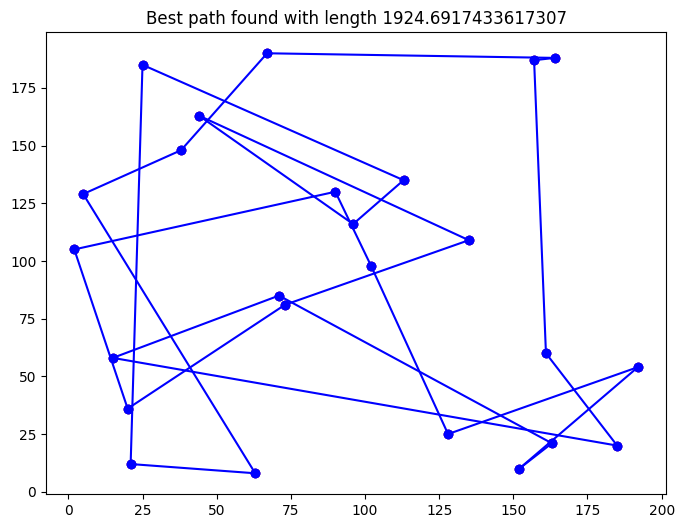

In [21]:
# Cell 7: Plotting the result
def plot_tsp_path(citylist, path):
    coordinates = [(city.x, city.y) for city in citylist]
    plt.figure(figsize=(8, 6))
    for i in range(len(path)):
        start = coordinates[path[i]]
        end = coordinates[path[(i + 1) % len(path)]]
        plt.plot([start[0], end[0]], [start[1], end[1]], 'bo-')
    plt.scatter(*zip(*coordinates), color='red')
    plt.title(f"Best path found with length {best_path_length}")
    plt.show()

plot_tsp_path(citylist, best_path)

In [22]:
#Cell 10
# Hyperparameter tuning for ACO and PSO using grid search
import time
from itertools import product

def hyperparameter_tuning(algorithm, citylist, param_grid, num_iterations=100, num_runs=5):
    best_params = None
    best_performance = float('inf')
    results = []

    for params in product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        
        performance_metrics = []
        for _ in range(num_runs):
            start_time = time.time()
            if algorithm == "ACO":
                best_path, best_distance = aco_tsp(create_distance_matrix(citylist), num_iterations=num_iterations, **param_dict)
            else:  # PSO
                distance_matrix = create_distance_matrix(citylist)
                best_path, best_distance = pso_tsp(distance_matrix, num_iterations=num_iterations, **param_dict)
            end_time = time.time()
            
            performance_metrics.append({
                'best_distance': best_distance,
                'computation_time': end_time - start_time
            })
        
        avg_performance = sum(m['best_distance'] for m in performance_metrics) / num_runs
        avg_time = sum(m['computation_time'] for m in performance_metrics) / num_runs
        
        results.append({
            'params': param_dict,
            'avg_performance': avg_performance,
            'avg_time': avg_time
        })
        
        if avg_performance < best_performance:
            best_performance = avg_performance
            best_params = param_dict

    return best_params, results

In [23]:
#Cell 11
#Grid search for ACO
aco_param_grid = {
    'num_ants': [3, 5, 7],
    'alpha': [0.5, 1.0, 1.5],
    'beta': [1.5, 2.0, 2.5],
    'rho': [0.3, 0.5, 0.7],
    'Q': [0.8, 1.0, 1.2]
}

#Grid search for PSO
pso_param_grid = {
    'num_particles': [3, 5, 7],
    'inertia_weight': [0.7, 0.9, 1.1],
    'cognitive_coeff': [1.0, 1.5, 2.0],
    'social_coeff': [1.0, 1.5, 2.0]
}

In [24]:
#Cell 12
# Running hyperparameter tuning for ACO and PSO
aco_best_params, aco_results = hyperparameter_tuning("ACO", citylist, aco_param_grid, num_iterations=5, num_runs=2)
print("Results for ACO: ", aco_results)
print("Best parameters for ACO: ", aco_best_params)

pso_best_params, pso_results = hyperparameter_tuning("PSO", citylist, pso_param_grid, num_iterations=5, num_runs=2)
print("Results for PSO: ", pso_results)
print("Best parameters for PSO: ", pso_best_params)

Iteration 1/5, Best path length: 1476.1374525899955
Iteration 2/5, Best path length: 1476.1374525899955
Iteration 3/5, Best path length: 1476.1374525899955
Iteration 4/5, Best path length: 1476.1374525899955
Iteration 5/5, Best path length: 1476.1374525899955
Iteration 1/5, Best path length: 1864.431068371771
Iteration 2/5, Best path length: 1721.9328327620115
Iteration 3/5, Best path length: 1602.5467936224338
Iteration 4/5, Best path length: 1602.5467936224338
Iteration 5/5, Best path length: 1602.5467936224338
Iteration 1/5, Best path length: 1564.0465426045264
Iteration 2/5, Best path length: 1564.0465426045264
Iteration 3/5, Best path length: 1467.8706294758183
Iteration 4/5, Best path length: 1467.8706294758183
Iteration 5/5, Best path length: 1467.8706294758183
Iteration 1/5, Best path length: 1399.7154581103896
Iteration 2/5, Best path length: 1399.7154581103896
Iteration 3/5, Best path length: 1399.7154581103896
Iteration 4/5, Best path length: 1399.7154581103896
Iteration 5/5

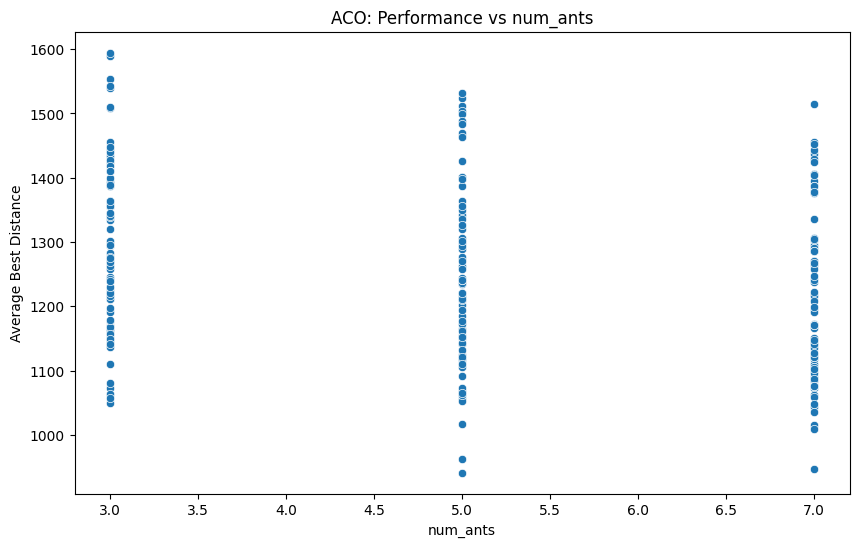

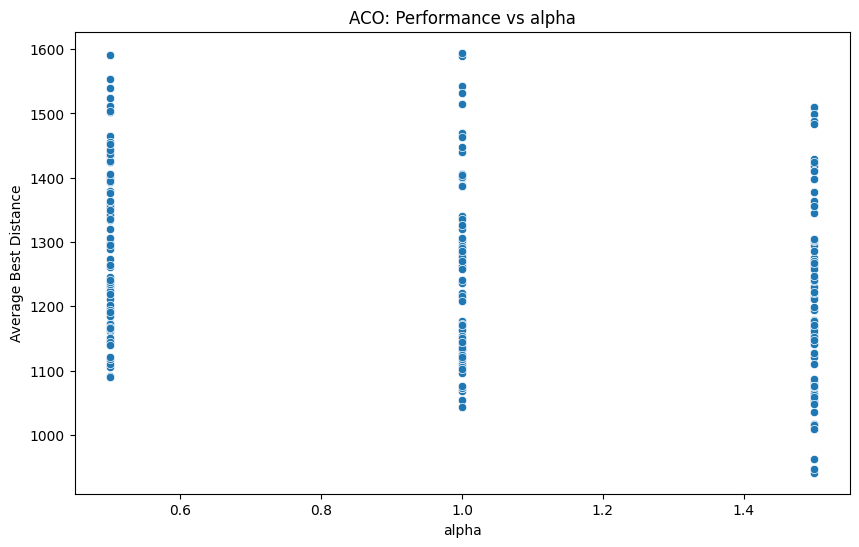

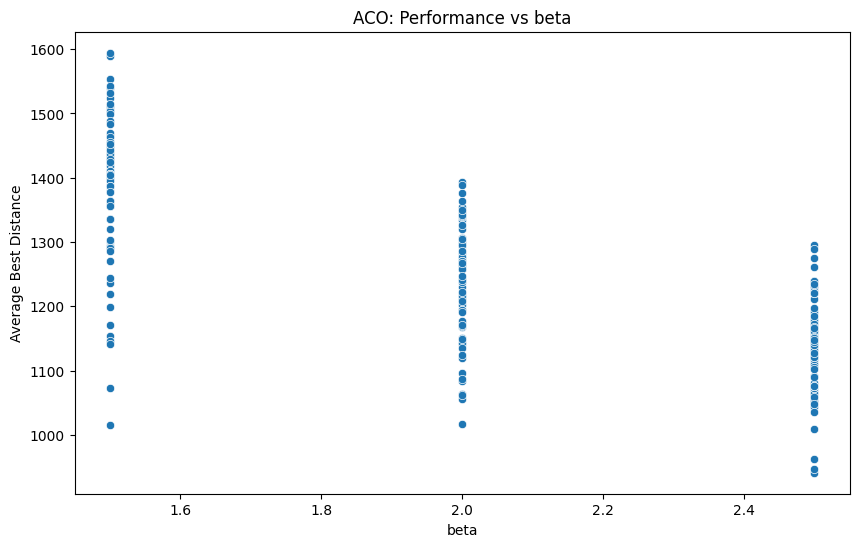

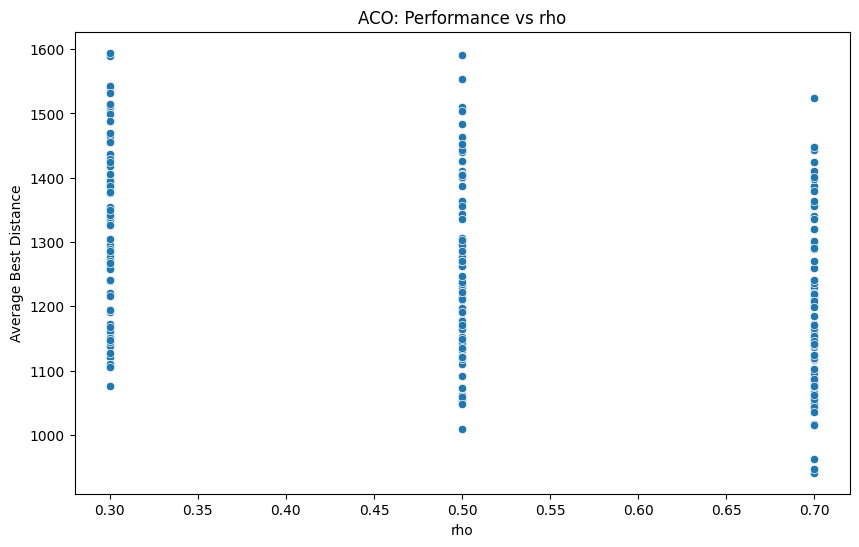

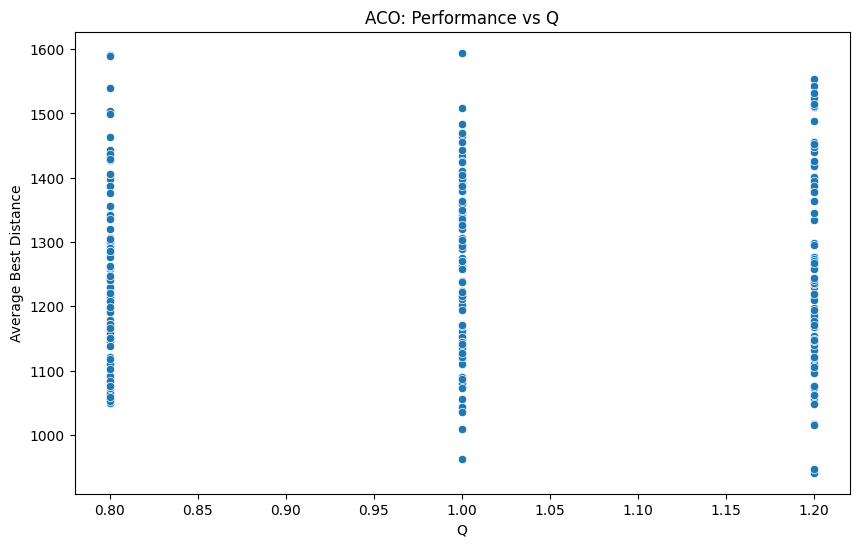

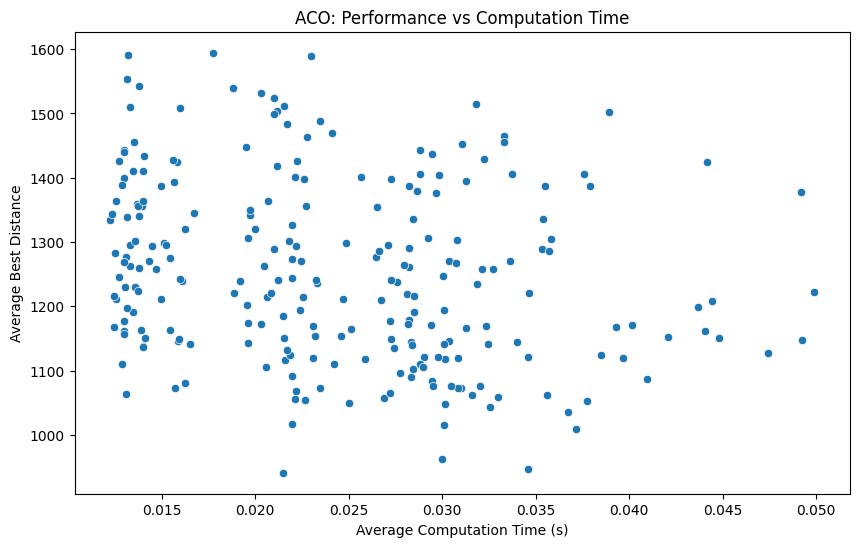

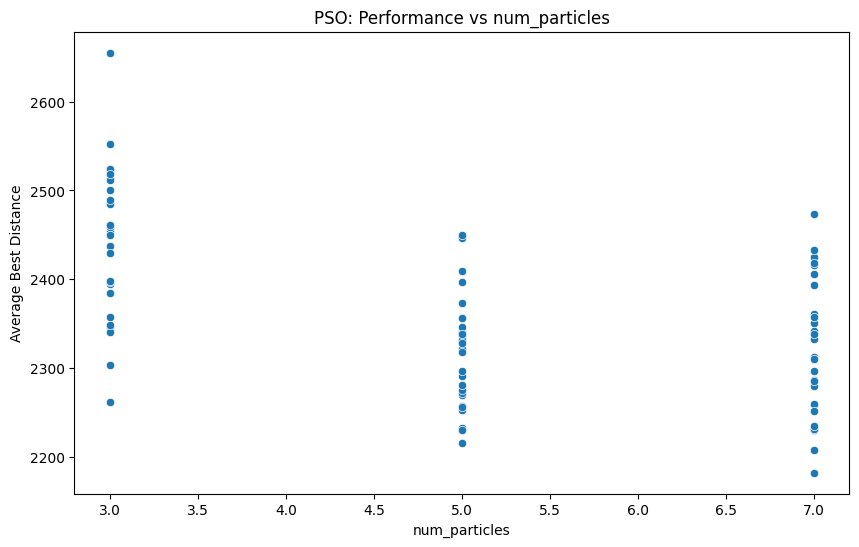

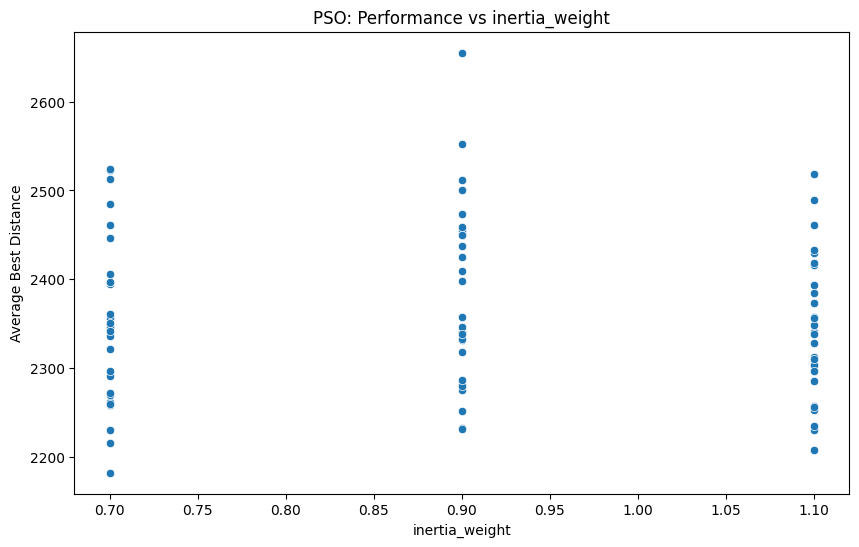

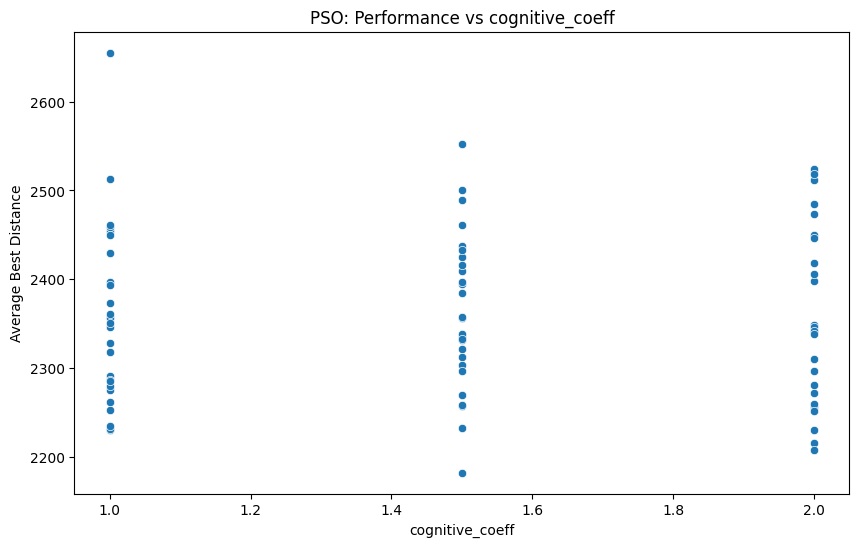

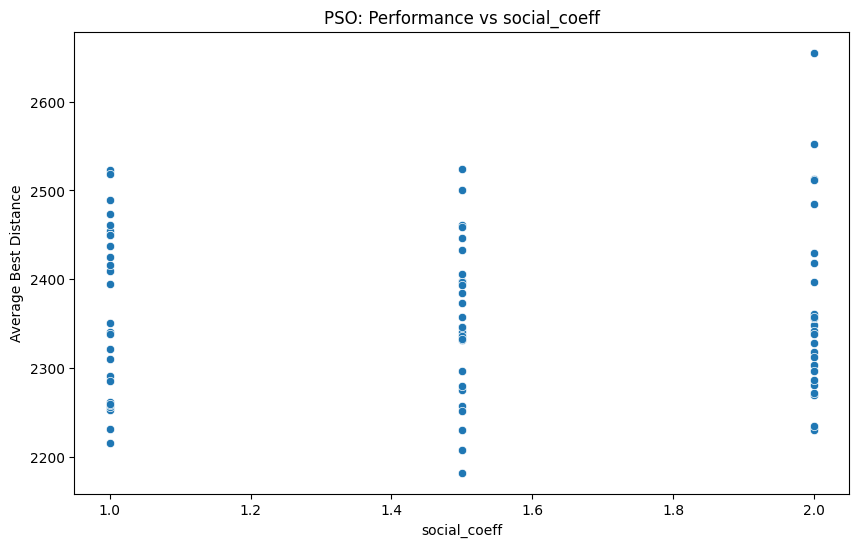

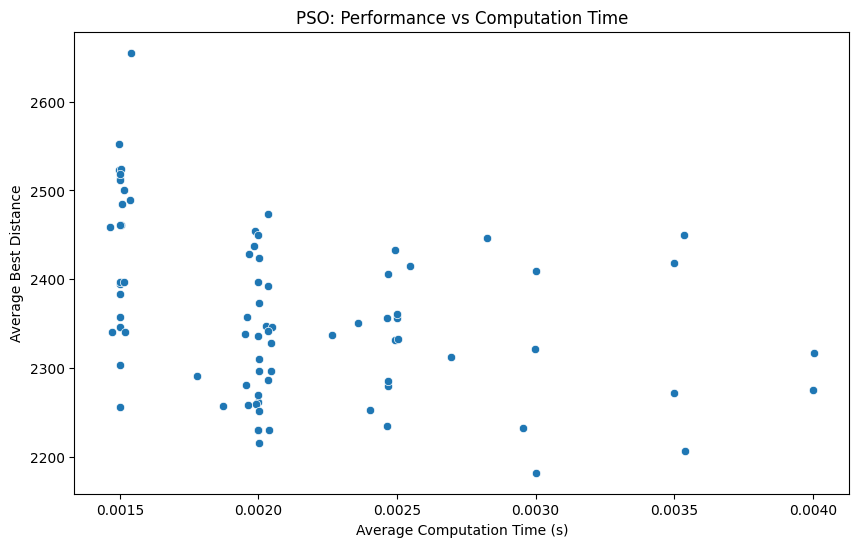

In [25]:
#Cell 13
# Analyzing the results and plotting the performance vs. hyperparameters
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(results, algorithm_name):
    df = pd.DataFrame(results)
    
    # Plot performance vs. different hyperparameters
    for param in df['params'].iloc[0].keys():
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df['params'].apply(lambda x: x[param]), y='avg_performance', data=df)
        plt.title(f'{algorithm_name}: Performance vs {param}')
        plt.xlabel(param)
        plt.ylabel('Average Best Distance')
        plt.show()
    
    # Plot computation time vs. performance
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='avg_time', y='avg_performance', data=df)
    plt.title(f'{algorithm_name}: Performance vs Computation Time')
    plt.xlabel('Average Computation Time (s)')
    plt.ylabel('Average Best Distance')
    plt.show()

analyze_results(aco_results, "ACO")
analyze_results(pso_results, "PSO")

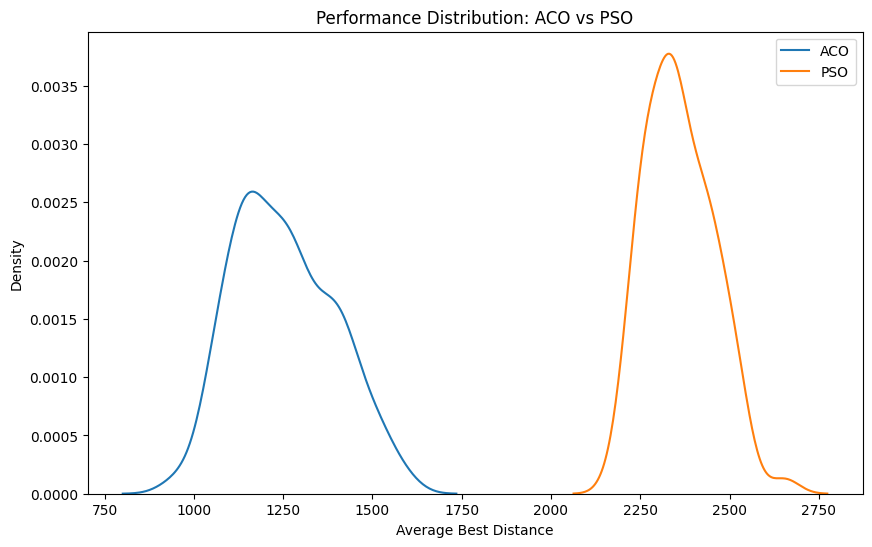

ACO Best Performance: 941.3680277543166
ACO Best Parameters: {'num_ants': 5, 'alpha': 1.5, 'beta': 2.5, 'rho': 0.7, 'Q': 1.2}
PSO Best Performance: 2181.903139739932
PSO Best Parameters: {'num_particles': 7, 'inertia_weight': 0.7, 'cognitive_coeff': 1.5, 'social_coeff': 1.5}
ACO Average Time: 0.024325587131358958
PSO Average Time: 0.002126686366987817


In [26]:
#Cell 14
# Performance comparison Algorithm for ACO and PSO
def compare_algorithms(aco_results, pso_results):
    aco_df = pd.DataFrame(aco_results)
    pso_df = pd.DataFrame(pso_results)
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=aco_df['avg_performance'], label='ACO')
    sns.kdeplot(data=pso_df['avg_performance'], label='PSO')
    plt.title('Performance Distribution: ACO vs PSO')
    plt.xlabel('Average Best Distance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    print("ACO Best Performance:", aco_df['avg_performance'].min())
    print("ACO Best Parameters:", aco_df.loc[aco_df['avg_performance'].idxmin()]['params'])
    print("PSO Best Performance:", pso_df['avg_performance'].min())
    print("PSO Best Parameters:", pso_df.loc[pso_df['avg_performance'].idxmin()]['params'])
    print("ACO Average Time:", aco_df['avg_time'].mean())
    print("PSO Average Time:", pso_df['avg_time'].mean())

compare_algorithms(aco_results, pso_results)

In [28]:
# Creating a summary table for ACO EMS, Hybrid PSO, ACO, and PSO
summary_data = {
    'Algorithm': ['ACO EMS', 'Hybrid PSO', 'ACO', 'PSO'],
    'Best Parameters': [
        aco_best_params,
        pso_best_params,
        {'num_ants': num_ants, 'alpha': alpha, 'beta': beta, 'rho': rho, 'Q': Q},
        {'num_particles': num_particles, 'inertia_weight': inertia_weight, 'cognitive_coeff': cognitive_coeff, 'social_coeff': social_coeff}
    ],
    'Best Distance': [
        best_distance,
        best_path_length,
        min([result['avg_performance'] for result in aco_results]),
        min([result['avg_performance'] for result in pso_results])
    ],
    'Convergence Time': [
        min([result['avg_time'] for result in aco_results]),
        min([result['avg_time'] for result in pso_results]),
        min([result['avg_time'] for result in aco_results]),
        min([result['avg_time'] for result in pso_results])
    ]
}

summary_table = pd.DataFrame(summary_data)
print(summary_table)

    Algorithm                                    Best Parameters  \
0     ACO EMS  {'num_ants': 5, 'alpha': 1.5, 'beta': 2.5, 'rh...   
1  Hybrid PSO  {'num_particles': 7, 'inertia_weight': 0.7, 'c...   
2         ACO  {'num_ants': 50, 'alpha': 1.0, 'beta': 2.0, 'r...   
3         PSO  {'num_particles': 50, 'inertia_weight': 0.9, '...   

   Best Distance  Convergence Time  
0     864.289460          0.012226  
1    1924.691743          0.001463  
2     941.368028          0.012226  
3    2181.903140          0.001463  
